In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R

from utils.fat_utils import Scene, Side
from utils import coor_utils, visualize

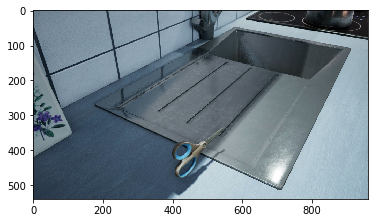

In [3]:
base = './fat/single/037_scissors_16k/kitchen_0/'
IND = 18
scene = Scene(base, IND)

plt.imshow(scene.left.img)

# Get transformed Pivots

NVDU's order:  
camera.draw() -> call projection  
-> opencv_to_opengl_matrix  
child_object.draw() -> world_transform_matrix  

m_viewport = [0, 0, 960, 540]
depth_range = [0, 2.1474845e9]

In [4]:
# Some preparation

scene = Scene(base, 18, parse_json=True)
left = scene.left

# Load proj_cuboid
proj_cuboid = np.float32(left.objects[0]['projected_cuboid'])

h, w = left.cap_height, left.cap_width

In [5]:
def ndc_to_win(pts_nx, viewport, depth_range):
    n, f = depth_range
    x, y, w, h = viewport
    pts = pts_nx * 0.5 * [w, h, f-n]
    pts = pts + 0.5 * np.float32([w, h, f+n])
    return pts

In [6]:
# Pivots
pts = np.float32([
    [0, 0, 0],
    [20.259, 0, 0],
    [0, 8.57, 0],
    [0, 0, 1.56],
])  # from cuboid_dimension
print(pts)

[[ 0.     0.     0.   ]
 [20.259  0.     0.   ]
 [ 0.     8.57   0.   ]
 [ 0.     0.     1.56 ]]


What do we have:  
1. __Tmw, (see below)__, but != pose_transform_permuted  
2. fixed_model_transform (used for point clouds only)
3. ~~camera_transform (not used)~~  
4. __opencv_to_opengl (used in viz/scene.py: Scene3d), SYM__
5. __projection_matrix, SYM__ 

_Note: Tmw(mine) = Tmw(nvdu).T _

The transformation becomes:  

P_2d = flip() @ NDC2WIN() @ perspective_division @ projection_matrix @ Tmw(mine) @ P_3d

Next, after some algebra simplification  
we composite `flip() @ NDC2WIN() @ perspective_division @ projection_matrix` as:  
**M_post @ homo_normalize() @ M_intrinsic**  

In [7]:
M_intrinsic = np.float32([
    [left.fx, 0, 0, 0],
    [0, left.fy, 0, 0],
    [0, 0, 1, 0],
])
M_post = np.float32([
    [1, 0, w/2],
    [0, 1, h/2],
    [0, 0, 1]
])

quat = left.get_params_from_key('quaternion_xyzw')[0]
rot = R.from_quat(quat).as_matrix()
transl = left.get_params_from_key('location')[0]
Tmw = coor_utils.concat_rot_transl_4x4(rot, transl) # T_model->world, confront OpenGL's

M_transform = M_intrinsic @ Tmw

pts_h = coor_utils.to_homo_nx(pts).T
print("Homo: \n", pts_h.T)

pts_h = M_transform @ pts_h
print("M_transform: \n", pts_h.T)

pts_h = coor_utils.normalize_homo_xn(pts_h)
print("norm_homo: \n", pts_h.T)

pts_h = M_post @ pts_h
print("M_post: \n", pts_h.T)
print("Win mean: ", pts_h.mean(0))
my_cuboid =  coor_utils.from_home_nx(pts_h.T)

Homo: 
 [[ 0.          0.          0.          1.        ]
 [20.25900078  0.          0.          1.        ]
 [ 0.          8.56999969  0.          1.        ]
 [ 0.          0.          1.55999994  1.        ]]
M_transform: 
 [[  198.03180828  7989.10053646    69.71949768]
 [-9834.16836056 14433.82757289    56.70129135]
 [ 1611.95253002 13945.64793479    72.87032451]
 [ 1077.22763263  8107.73171098    68.67080235]]
norm_homo: 
 [[   2.84040785  114.5891867     1.        ]
 [-173.43817268  254.55906257    1.        ]
 [  22.12083644  191.37622933    1.        ]
 [  15.68683626  118.06665182    1.        ]]
M_post: 
 [[482.84040785 384.5891867    1.        ]
 [306.56182732 524.55906257   1.        ]
 [502.12083644 461.37622933   1.        ]
 [495.68683626 388.06665182   1.        ]]
Win mean:  [289.47653152 277.37362996 321.49902193 294.91782936]


[[396.5066 404.7391]
 [546.5868 294.0818]
 [562.4931 371.7707]
 [423.1461 492.6196]
 [383.7202 400.5399]
 [533.9136 292.1598]
 [550.1267 368.8842]
 [410.5601 487.2119]]


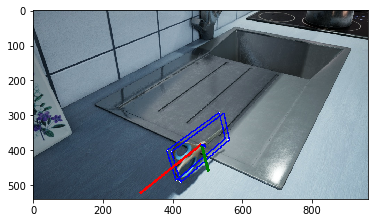

In [10]:
img = Image.fromarray(left.img.copy())
visualize.draw_proj_cuboid_image(img, proj_cuboid, color='blue')
visualize.draw_pivots_image(img, my_cuboid, thickness=8)
plt.imshow(img)
print(proj_cuboid)

# Get transformed CUBOID

In [11]:
# Some preparation
scene = Scene(base, IND, parse_json=True)
left = scene.left

# Load proj_cuboid
proj_cuboid = np.float32(left.objects[0]['projected_cuboid'])

h, w = left.cap_height, left.cap_width

In [12]:
width, height, depth = left.object_settings['exported_objects'][0]['cuboid_dimensions']
cx, cy, cz = 0, 0, 0
# NOTE: following use OpenCV's coordinate convention, 
# in fat_utils.py, we use OpenGL's convention

# X axis point to the right
right = cx + width / 2.0
_left = cx - width / 2.0
# Y axis point downward
top = cy - height / 2.0
bottom = cy + height / 2.0
# Z axis point forward
front = cz + depth / 2.0
rear = cz - depth / 2.0

# List of 8 vertices of the box       
pts = np.float32([
    [_left, top, front],     # Front Top Left
    [right, top, front],    # Front Top Right
    [right, bottom, front], # Front Bottom Right
    [_left, bottom, front],  # Front Bottom Left
    [_left, top, rear],      # Rear Top Left
    [right, top, rear],     # Rear Top Right
    [right, bottom, rear],  # Rear Bottom Right
    [_left, bottom, rear],   # Rear Bottom Left
])
print(pts)

[[-10.1299   -4.3765    0.78275]
 [ 10.1299   -4.3765    0.78275]
 [ 10.1299    4.3765    0.78275]
 [-10.1299    4.3765    0.78275]
 [-10.1299   -4.3765   -0.78275]
 [ 10.1299   -4.3765   -0.78275]
 [ 10.1299    4.3765   -0.78275]
 [-10.1299    4.3765   -0.78275]]


In [13]:
my_cuboid = left.transform_point_cloud(pts, 0)

[[396.5066 404.7391]
 [546.5868 294.0818]
 [562.4931 371.7707]
 [423.1461 492.6196]
 [383.7202 400.5399]
 [533.9136 292.1598]
 [550.1267 368.8842]
 [410.5601 487.2119]]


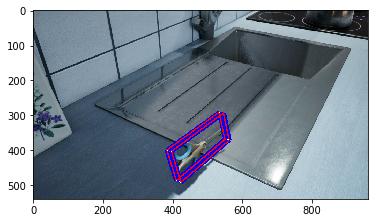

In [14]:
img = Image.fromarray(np.ones([h, w, 3], dtype=np.uint8) * 255)
img = Image.fromarray(left.img.copy())
visualize.draw_proj_cuboid_image(img, proj_cuboid, color='blue', thickness=12)
visualize.draw_proj_cuboid_image(img, my_cuboid, color='red', thickness=4)
plt.imshow(img)
print(proj_cuboid)

In [15]:
left.objects[0]['bounding_box']

{'top_left': [312.4453125, 387.9092102050781],
 'bottom_right': [484.3565979003906, 554.1065063476562]}

# Get transformed point cloud in 2D

In [16]:
from utils import data as datalib

model_root = './fat/ycb_models_nvdu_aligned_cm/037_scissors/google_512k/'
pts = datalib.load_obj(model_root+'textured.obj')

# Same
# pts = datalib.ply_vtx(model_root + 'nontextured.ply') 

# model_root = '/home/damon/Github/Dataset_Utilities/nvdu/data/ycb/aligned_cm/037_scissors/google_16k/'
# pts = datalib.load_obj(model_root+'textured.obj')

scene = Scene(base, 18, parse_json=True)
left = scene.left

h, w = left.cap_height, left.cap_width

In [17]:
print(len(pts))

262140


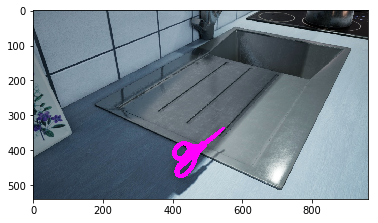

In [18]:
pts_2d = left.transform_point_cloud(pts, 0)
pts_ind = np.floor(pts_2d).astype(int)

img = left.img.copy()
img[pts_ind[:, 1], pts_ind[:, 0], :] = (255, 0, 255)  # img[y, x, :]
plt.imshow(img)

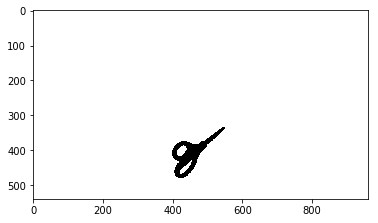

In [19]:
img = np.ones([h, w, 3])
img[pts_ind[:, 1], pts_ind[:, 0], :] = 0  # img[y, x, :]
plt.imshow(img)

# Randomly generate some

In [20]:
import os
import glob

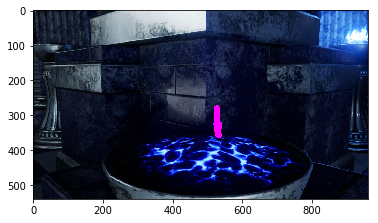

In [21]:
single_root = './fat/single/'
mod = np.random.choice(glob.glob(os.path.join(single_root, '*')))
place = np.random.choice(glob.glob(os.path.join(mod, '*')))

num_scenes = len(glob.glob(os.path.join(place, '*.left.jpg')))
index = np.random.choice(num_scenes)

scene = Scene(place, index)
model_root = './fat/ycb_models_nvdu_aligned_cm/'
plt.imshow(scene.left.visualize_object(0, model_root))